## 進階機器學習 HW4-2
#### Split the dataset in HW3_ text.csv **into 70% training and 30% testing subsets**. **Fine-tune a BERT model** using the training data and perform text classification on the test set. Present the **confusion matrix** based on the test results. 
* 學號: B103040047
* 姓名: 周安

In [530]:
SOURCE_FILE = "HW3_text.csv"

In [531]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import pandas as pd

In [532]:
import random

import torch
import numpy as np

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return generator
generator = same_seeds(122)

Load the csv file.

In [533]:
text_df = pd.read_csv(SOURCE_FILE)
print(text_df)
print(text_df["message"][583])

                                               message sentiment
0                           I really enjoyed the movie  positive
1                                The food was terrible  negative
2                   I'm not sure how I feel about this   neutral
3                            The service was excellent  positive
4                               I had a bad experience  negative
..                                                 ...       ...
579  I have to cancel my vacation plans because I c...  negative
580  My computer crashed and I lost all my importan...  negative
581  I got into a car accident and my car is totale...  negative
582  I have a cold and can't stop coughing. it's re...  negative
583  I just found out my ex is dating someone new. ...  negative

[584 rows x 2 columns]
I just found out my ex is dating someone new. I feel so heartbroken 💔😢


## Load the tokenizer.

In [534]:
from transformers import BertTokenizer # or it can use AutoTokenizer
from IPython.display import clear_output
from tqdm import tqdm
PRETRAINED_MODEL_NAME = "bert-base-uncased" # pre-trained on cased ENG

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

clear_output()
print("PyTorch version：", torch.__version__)

PyTorch version： 2.3.1


In [535]:
vocab = tokenizer.vocab
print("DICT SIZE:", len(vocab))

DICT SIZE: 30522


In [536]:
print(tokenizer.special_tokens_map)

{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [537]:
# Print all special tokens
print("All special tokens:", tokenizer.all_special_tokens)

# Print all special token IDs
print("All special token IDs:", tokenizer.all_special_ids)

# Individual tokens
print("[CLS] token:", tokenizer.cls_token)
print("[SEP] token:", tokenizer.sep_token)
print("[PAD] token:", tokenizer.pad_token)
print("[MASK] token:", tokenizer.mask_token)
print("[UNK] token:", tokenizer.unk_token)

# You can also get their corresponding IDs
print("[CLS] token ID:", tokenizer.cls_token_id)

All special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
All special token IDs: [100, 102, 0, 101, 103]
[CLS] token: [CLS]
[SEP] token: [SEP]
[PAD] token: [PAD]
[MASK] token: [MASK]
[UNK] token: [UNK]
[CLS] token ID: 101


### Test on sentence to see the result of different tokenizer usage.
* The **emoji** will be treated as `[UNK]`.
* `'##broken'` is derived from `heartbroken`.

In [538]:
text = text_df["message"][583]
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(text)
print(tokens)
print(ids)

I just found out my ex is dating someone new. I feel so heartbroken 💔😢
['i', 'just', 'found', 'out', 'my', 'ex', 'is', 'dating', 'someone', 'new', '.', 'i', 'feel', 'so', 'heart', '##broken', '[UNK]']
[1045, 2074, 2179, 2041, 2026, 4654, 2003, 5306, 2619, 2047, 1012, 1045, 2514, 2061, 2540, 29162, 100]


In [539]:
ids = tokenizer.encode(text) # add [CLS] and [SEP] automatically
print(ids)
text_decode = tokenizer.decode(ids)
print(text_decode)

[101, 1045, 2074, 2179, 2041, 2026, 4654, 2003, 5306, 2619, 2047, 1012, 1045, 2514, 2061, 2540, 29162, 100, 102]
[CLS] i just found out my ex is dating someone new. i feel so heartbroken [UNK] [SEP]


In [540]:
es = tokenizer.encode_plus(text)
print(es)

{'input_ids': [101, 1045, 2074, 2179, 2041, 2026, 4654, 2003, 5306, 2619, 2047, 1012, 1045, 2514, 2061, 2540, 29162, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [541]:
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt") # return like a dict
print(inputs)
print(type(inputs))

{'input_ids': tensor([[  101,  1045,  2074,  2179,  2041,  2026,  4654,  2003,  5306,  2619,
          2047,  1012,  1045,  2514,  2061,  2540, 29162,   100,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
<class 'transformers.tokenization_utils_base.BatchEncoding'>


### Choose three tensors as BERT's input:
1. `input_ids`: token ID
2. `token_type_ids`: indicate sentence number
3. `attention_mask`: check if this token need to get attention

In [542]:
es = tokenizer.encode_plus(
    text,
    max_length = 20,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'pt' # for torch
)
print(es)

{'input_ids': tensor([[  101,  1045,  2074,  2179,  2041,  2026,  4654,  2003,  5306,  2619,
          2047,  1012,  1045,  2514,  2061,  2540, 29162,   100,   102,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}


### Parameter Setting

In [543]:
# Hyper Parameters
LR = 0.0001
batch_size_train = 16
batch_size_val = 16
NUM_EPOCHS = 8

LABELS = {'negative':0, 'positive':1, 'neutral':2}
MAX_TOKEN_LENGTH = 30 
# if sentences aren't as long as MAX_SEQUENCE_LENGTH, padding it in front of the first word
print(f"MAX_TOKEN_LENGTH = {MAX_TOKEN_LENGTH}")

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

MAX_TOKEN_LENGTH = 30
Train on cuda.


### Create dataset
* Each tensor is MAX_TOKEN_LENGTH = 26 dimension.

In [544]:
class TextDataset(Dataset):
    def __init__(self, df, labels, tokenizer, max_token_len, mode="train"):
        self.df = df
        self.label_type = labels
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.mode = mode # "train" or "val" or "test"

        self.num_class = len(self.label_type)
    # transform text to its id
    def tokenize(self,input_text):
        inputs = self.tokenizer.encode_plus(
            input_text,
            max_length = self.max_token_len,
            truncation = True,
            padding = 'max_length',
            return_tensors = 'pt' # for torch
        )
        # get the first result, unsqueeze one dimension return from encode_plus
        ids = inputs['input_ids'][0] 
        mask = inputs['attention_mask'][0]
        token_type_ids = inputs["token_type_ids"][0]
        
        return ids, mask, token_type_ids
    
    def __getitem__(self,idx):
        msg = self.df['message'][idx]
        # to encode this msg
        ids, mask, token_type_ids = self.tokenize(msg) # return three tensors

        if self.mode != "test":
                label = self.label_type[self.df['sentiment'][idx]]
        else:
                label = 0 # not used
        label = torch.tensor(label, dtype=torch.long)
        return ids, mask, token_type_ids, label

    def __len__(self):
        return len(self.df)

In [545]:
from torch.utils.data import random_split

train_dataset = TextDataset(text_df, LABELS, tokenizer, MAX_TOKEN_LENGTH, mode="train")

# divide into 70% and 30%
total_len = len(train_dataset)
train_len = int(0.7 * total_len)
val_len = total_len - train_len

train_subset, val_subset = random_split(train_dataset, [train_len, val_len], generator=generator)
print("Length of train_subset:", len(train_subset))
print("Length of val_subset:", len(val_subset))
# create  dataloader for training
train_dataloader = DataLoader(train_subset, batch_size=batch_size_train, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size_val, shuffle=False, pin_memory=True)

Length of train_subset: 408
Length of val_subset: 176


In [546]:
# see if it operates correctly
# See the data's shape
for x, y, z, label in val_dataloader:
    print(x.shape,y.shape,z.shape,label.shape)
    print(label)
    break

torch.Size([16, 30]) torch.Size([16, 30]) torch.Size([16, 30]) torch.Size([16])
tensor([0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1])


#### Below, it shows the length of available token length in order to adjust the `MAX_TOKEN_LENGTH`

In [547]:
max = 0
for ids, mask, token_type_ids, _ in tqdm(train_dataloader):
    temp = torch.sum(mask, dim=1)
    value, idx = torch.max(temp, dim=0)
    if value > max:
        max = value

for ids, mask, token_type_ids, _ in tqdm(val_dataloader):
    temp = torch.sum(mask, dim=1)
    value, idx = torch.max(temp, dim=0)
    if value > max:
        max = value
print(max)

100%|██████████| 11/11 [00:00<00:00, 269.31it/s]

tensor(28)


### See distribution of labels in dataset.

In [548]:
LABELS

{'negative': 0, 'positive': 1, 'neutral': 2}

In [549]:
distribution = [0, 0, 0]
for _, _, _, y in tqdm(train_dataloader):
    for label in y:
        distribution[int(label)] += 1
percentage = np.array(distribution) / len(train_subset) * 100
for i, number in enumerate(percentage):
    print(f"{i} : {number:.4f}%")
distribution = [0, 0, 0]
for _, _, _, y in tqdm(val_dataloader):
    for label in y:
        distribution[int(label)] += 1
percentage = np.array(distribution) / len(train_subset) * 100
for i, number in enumerate(percentage):
    print(f"{i} : {number:.4f}%")

100%|██████████| 26/26 [00:00<00:00, 288.22it/s]


0 : 25.4902%
1 : 28.9216%
2 : 45.5882%


100%|██████████| 11/11 [00:00<00:00, 264.67it/s]

0 : 10.5392%
1 : 14.7059%
2 : 17.8922%


### Define BERT model (Use designed model from transformer)
* [BertForSequenceClassification](https://huggingface.co/docs/transformers/v4.34.0/en/model_doc/bert#transformers.BertForSequenceClassification)
    * It is pre-trained BERT + linear classsifier
    * Choose 3 Input tensors:
    1. ids `(batch_size, sequence_length)`
    2. mask `(batch_size, sequence_length)`
    3. token_id_type `(batch_size, sequence_length)`
    * Output:
        * Based on above settings, model will return `logits`(torch.FloatTensor of shape `(batch_size, config.num_labels))`  Classification scores (**before SoftMax**).  
    * If I don't give `position_ids`, BERT will define it as `[0, 1, ..., seq_len-1]`
    * If I give label to model, it can return `loss`.
    * It shows this BERT model's hidden state dimension is **768**.

In [550]:
from transformers import BertForSequenceClassification
# Can do classification
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=len(LABELS)).to(device)
# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))
clear_output()
print("Classifier Model structure:")
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))

Classifier Model structure:

name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


In [551]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")
    '''
    It print:
    classifier.weight: requires_grad=True
    classifier.bias: requires_grad=True
    '''

bert.embeddings.word_embeddings.weight: requires_grad=True
bert.embeddings.position_embeddings.weight: requires_grad=True
bert.embeddings.token_type_embeddings.weight: requires_grad=True
bert.embeddings.LayerNorm.weight: requires_grad=True
bert.embeddings.LayerNorm.bias: requires_grad=True
bert.encoder.layer.0.attention.self.query.weight: requires_grad=True
bert.encoder.layer.0.attention.self.query.bias: requires_grad=True
bert.encoder.layer.0.attention.self.key.weight: requires_grad=True
bert.encoder.layer.0.attention.self.key.bias: requires_grad=True
bert.encoder.layer.0.attention.self.value.weight: requires_grad=True
bert.encoder.layer.0.attention.self.value.bias: requires_grad=True
bert.encoder.layer.0.attention.output.dense.weight: requires_grad=True
bert.encoder.layer.0.attention.output.dense.bias: requires_grad=True
bert.encoder.layer.0.attention.output.LayerNorm.weight: requires_grad=True
bert.encoder.layer.0.attention.output.LayerNorm.bias: requires_grad=True
bert.encoder.laye

In [552]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

count_parameters(model)

Total parameters: 109484547
Trainable parameters: 109484547


In [553]:
print("BERT backbone:")
count_parameters(model.bert)

print("Classifier head:")
count_parameters(model.classifier)

BERT backbone:
Total parameters: 109482240
Trainable parameters: 109482240
Classifier head:
Total parameters: 2307
Trainable parameters: 2307


In [554]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

### Define the train, val, test workflow.

In [555]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch(train_dataloader, model):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for ids, mask, token_type_ids, y in tqdm(train_dataloader):
        ids, mask, token_type_ids, y = ids.to(device), mask.to(device), token_type_ids.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output = model(
            input_ids = ids,
            attention_mask = mask,
            token_type_ids = token_type_ids 
        )
        # print(output.keys()) # odict_keys(['logits']), it shows the result can be accessed by 'logits'
        # print(output.logits)
        # print(output.logits.shape) # (Batch_size, num_labels)
        # see loss
        loss = criterion(output.logits, y)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(output.logits, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader, model):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for ids, mask, token_type_ids, y in tqdm(val_dataloader):
            ids, mask, token_type_ids, y = ids.to(device), mask.to(device), token_type_ids.to(device), y.to(device)
            # predicting
            output = model(
                input_ids = ids,
                attention_mask = mask,
                token_type_ids = token_type_ids 
            )
            # see loss
            loss = criterion(output.logits, y)

            val_loss += loss.item()
            probs = torch.nn.functional.softmax(output.logits, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

def test(test_dataloader, model, type="test"):
    pred_labels = []
    total_probs = []
    true_labels = [] # for testing train dataset
    model.eval()
    with torch.no_grad():
        if type == "test": # Don't have gorund truth
            for ids, mask, token_type_ids, _ in tqdm(test_dataloader):
                ids, mask, token_type_ids = ids.to(device), mask.to(device), token_type_ids.to(device)
                # predicting
                output = model(
                    input_ids = ids,
                    attention_mask = mask,
                    token_type_ids = token_type_ids 
                )
                probs = torch.nn.functional.softmax(output.logits, dim=1)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
            return pred_labels

        else:
            for ids, mask, token_type_ids, y in tqdm(test_dataloader):
                ids, mask, token_type_ids, y = ids.to(device), mask.to(device), token_type_ids.to(device), y.to(device)
                # predicting
                output = model(
                    input_ids = ids,
                    attention_mask = mask,
                    token_type_ids = token_type_ids 
                )
                probs = torch.nn.functional.softmax(output.logits, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
                true_labels.extend(y.cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels, true_labels

In [556]:
def plt_loss_accuracy_fig(Total_training_loss, Total_validation_loss, Total_training_accuracy, Total_validation_accuracy):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.plot(range(len(Total_validation_loss)), Total_validation_loss, 'g-', label='validation_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(range(len(Total_training_accuracy)), Total_training_accuracy, 'r-', label='Training_accuracy')
    plt.plot(range(len(Total_validation_accuracy)), Total_validation_accuracy, 'y-', label='Validation_accuracy')
    plt.title('Training & Validation accuracy')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [557]:
def plot_confusion_matrix(pred_labels, true_labels, num_classes=len(LABELS)):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

### Start Training...
#### Train on train_dataset and see predicted result on val_dataset(test_dataset).

In [558]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_val_acc = []
total_train_loss = []
total_val_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader, model)
    val_acc, val_loss = val_epoch(val_dataloader, model)
    # record the training data
    total_train_acc.append(train_acc)
    total_val_acc.append(val_acc)

    total_train_loss.append(train_loss)
    total_val_loss.append(val_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}, val_acc = {:.4f}, val_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss, val_acc, val_loss))
    # update model pth when larger val_acc happens
    if(val_acc > max_accuracy):
        max_accuracy = val_acc
        save_parameters = True
        if save_parameters:
            path = 'BERT_FINETUNE_sentiment_classifier.pth'
            torch.save(model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, val_acc))

# save the final epoch's model
path = 'BERT_FINETUNE_sentiment_classifier_final_epoch.pth'
torch.save(model.state_dict(), path)
print("\t\33[92m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 11/11 [00:00<00:00, 20.02it/s]


Epoch[ 1/ 8] : train_acc = 0.7181, train_loss = 0.0428, val_acc = 0.9091, val_loss = 0.0178
	====Save model parameters in BERT_FINETUNE_sentiment_classifier.pth when val_acc is 0.9091====


100%|██████████| 11/11 [00:00<00:00, 20.27it/s]


Epoch[ 2/ 8] : train_acc = 0.9510, train_loss = 0.0128, val_acc = 0.8977, val_loss = 0.0186


100%|██████████| 11/11 [00:00<00:00, 22.02it/s]


Epoch[ 3/ 8] : train_acc = 0.9755, train_loss = 0.0058, val_acc = 0.9545, val_loss = 0.0093
	====Save model parameters in BERT_FINETUNE_sentiment_classifier.pth when val_acc is 0.9545====


100%|██████████| 11/11 [00:00<00:00, 20.28it/s]


Epoch[ 4/ 8] : train_acc = 0.9632, train_loss = 0.0085, val_acc = 0.9261, val_loss = 0.0121


100%|██████████| 11/11 [00:00<00:00, 23.13it/s]


Epoch[ 5/ 8] : train_acc = 0.9828, train_loss = 0.0031, val_acc = 0.9602, val_loss = 0.0077
	====Save model parameters in BERT_FINETUNE_sentiment_classifier.pth when val_acc is 0.9602====


100%|██████████| 11/11 [00:00<00:00, 21.12it/s]


Epoch[ 6/ 8] : train_acc = 0.9975, train_loss = 0.0005, val_acc = 0.9716, val_loss = 0.0057
	====Save model parameters in BERT_FINETUNE_sentiment_classifier.pth when val_acc is 0.9716====


100%|██████████| 11/11 [00:00<00:00, 20.71it/s]


Epoch[ 7/ 8] : train_acc = 1.0000, train_loss = 0.0001, val_acc = 0.9773, val_loss = 0.0057
	====Save model parameters in BERT_FINETUNE_sentiment_classifier.pth when val_acc is 0.9773====


100%|██████████| 11/11 [00:00<00:00, 20.28it/s]


Epoch[ 8/ 8] : train_acc = 1.0000, train_loss = 0.0001, val_acc = 0.9773, val_loss = 0.0059
	====Save FINAL model parameters in BERT_FINETUNE_sentiment_classifier_final_epoch.pth====


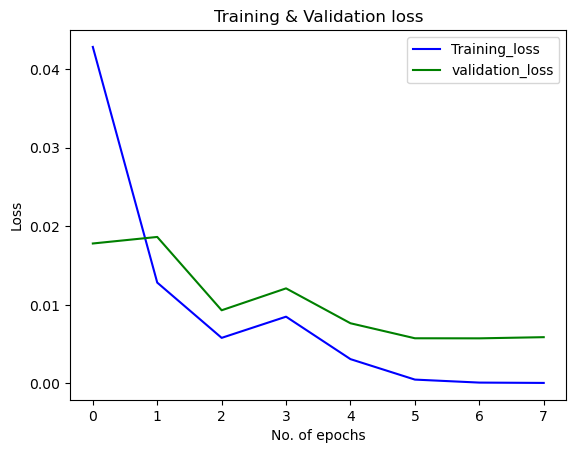

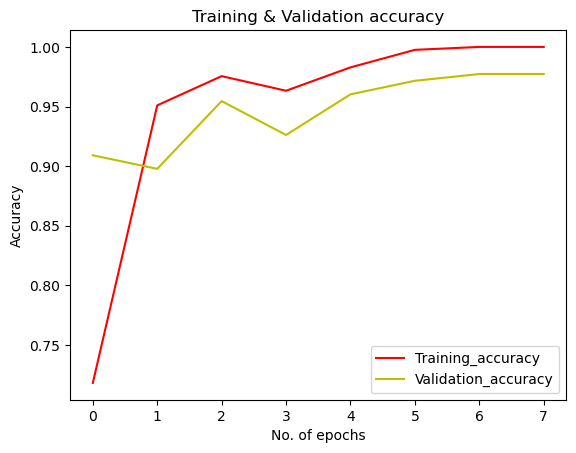

In [559]:
plt_loss_accuracy_fig(total_train_loss, total_val_loss, total_train_acc, total_val_acc)

### Test on test dataset. Present the confusion matrix based on the test results.

Load pth from BERT_FINETUNE_sentiment_classifier.pth


100%|██████████| 11/11 [00:00<00:00, 14.29it/s]

Top-1 Accuracy: 0.9773


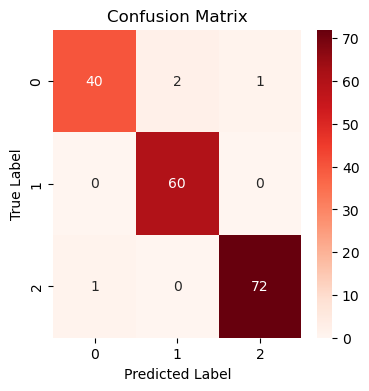

In [561]:
# Load back the model
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=len(LABELS)).to(device)
clear_output()
pth_path = 'BERT_FINETUNE_sentiment_classifier.pth'
state_dict = torch.load(pth_path)
model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

total_val_probs, val_pred_labels, true_labels = test(val_dataloader, model, type="val")

top_1_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_val_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1


# Calculate the final accuracy
top_1_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
plot_confusion_matrix(val_pred_labels, true_labels)